# 1. 모듈 load

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import torchvision.models as models
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

from PIL import Image

import re
import os
import cv2

# 2. 장치 확인

In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print(f'Using Pytorch Version: {torch.__version__}, Device: {DEVICE}')

Using Pytorch Version: 1.9.0, Device: cuda


# 3. 데이터 load

In [3]:
webtoons = pd.read_csv('data/using_thumbs.csv')

In [4]:
webtoons = webtoons.drop('Unnamed: 0', axis=1)

In [5]:
webtoons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7460 entries, 0 to 7459
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         7460 non-null   int64 
 1   p_id       7460 non-null   int64 
 2   title      7460 non-null   object
 3   platform   7460 non-null   object
 4   thumbnail  7460 non-null   object
dtypes: int64(2), object(3)
memory usage: 291.5+ KB


## 3-1. 다운로드

In [6]:
def download_thumbs(webtoons):
    thumbs_path = []
    path = 'thumbs/'
    for _, (index, p_id, title, platform, url) in webtoons.iterrows():
        title = platform + '_' +str(p_id) + '.jpg'
        thumbs_path.append(title)
        title = path + title
        #!wget -q {url} -O {title}
        
    thumbs_byte = []
    for thumb in thumbs_path:
        try: 
            thumbs_byte.append(Image.open(path + thumb))
        except:
            break
    
    return thumbs_path, thumbs_byte

## 3-2. Path Open

In [7]:
def get_path(folder):
    path=[]
    for j in os.listdir(folder):      
        p = folder+j
        path.append(p)
    return path

In [8]:
path = 'thumbs/'
thumb_path = get_path(path)

In [9]:
print(thumb_path[0], len(thumb_path))

thumbs/daum_0.jpg 7460


# 4. 데이터 전처리

## 데이터 전처리

In [10]:
class MyTransform():

    def __init__(self, mean, std, h, w):
        self.transformer = transforms.Compose([
            transforms.Resize((h,w)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])

    def __call__(self, img):
        return self.transformer(img)

In [11]:
class MyDataset(Dataset):

    def __init__(self, dataset, w, h, transformer):
        self.dataset = dataset
        self.w = w
        self.h = h
        self.transformer = transformer

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx): #<-요기서부터 전처리부분이에요
        path = self.dataset[idx]
        img = Image.open(path)
        if img.mode != "RGB":
            img = img.convert("RGB")
        
        img = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2RGB)
        percent = 1
        if img.shape[0] > img.shape[1]:
            percent = self.w / img.shape[0]
        else:
            percent = self.h / img.shape[1]
        
        img = cv2.resize(img, dsize=(0,0), fx=percent, fy=percent, interpolation=cv2.INTER_LINEAR)
        x,y,weight,height = (0,0,img.shape[1],img.shape[0])

        # padding 
        w_x = max((self.w-(weight-x))/2, 0)
        h_y = max((self.h-(height-y))/2, 0)
        padding = np.float32([[1,0,w_x], [0,1,h_y]])
        img = cv2.warpAffine(img, padding, (self.w, self.h), borderValue = (255,255,255))
        transformed = self.transformer(Image.fromarray(img))

        return transformed

In [12]:
h, w = 125, 125
mean = (0.6636, 0.5991, 0.5766)
std = (0.2852, 0.2843, 0.2775)

In [13]:
dataset = MyDataset(thumb_path, w, h, MyTransform(mean, std, h, w))
loader = DataLoader(dataset, batch_size= len(thumb_path))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


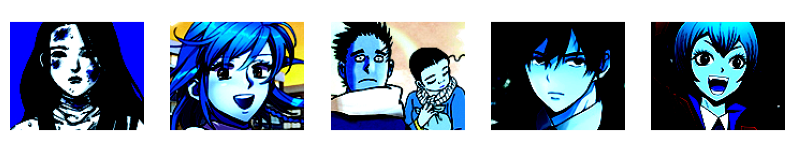

In [14]:
pltsize = 2
plt.figure(figsize = (5 * pltsize, pltsize))

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    plt.imshow(np.transpose(dataset[7000+i], (1,2,0)))
    #plt.title(f'title: {thumb_path[7000+i]}')
plt.show()

#### 평균, 표준편차

In [15]:
'''CHANNEL = 3 
mean = torch.zeros(3)
std = torch.zeros(3)

for i, img in enumerate(dataset):
    if i%100 == 0:
        print(i, end = " ")
    for ch in range(CHANNEL):
        mean[ch] += img[ch, :, :].mean()
        std[ch] += img[ch, :, :].std()

mean.div_(len(dataset))
std.div_(len(dataset))

print(mean, std)'''

'CHANNEL = 3 \nmean = torch.zeros(3)\nstd = torch.zeros(3)\n\nfor i, img in enumerate(dataset):\n    if i%100 == 0:\n        print(i, end = " ")\n    for ch in range(CHANNEL):\n        mean[ch] += img[ch, :, :].mean()\n        std[ch] += img[ch, :, :].std()\n\nmean.div_(len(dataset))\nstd.div_(len(dataset))\n\nprint(mean, std)'

# 5. Pre-trained 모델 불러오기

In [16]:
model = models.mobilenet_v3_small(pretrained=True).to(DEVICE).eval()
layer = model._modules.get('avgpool')
model.eval()

MobileNetV3(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (relu): ReLU(inplace=True)
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
        )
        (2): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_r

# 6. Feature Extraction

In [17]:
def get_features(x, model):
    
    x = Variable(x) # backpropagation X
    
    embedding = torch.zeros(576)    
    def hook(module, inp, out):
        embedding.copy_(out.data.reshape(out.data.size(1)))
    
    h = layer.register_forward_hook(hook)
    model(x)
    h.remove()
    
    return embedding

In [18]:
def get_ith_loss(row, sim):
    
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    start.record()
    
    row_tensor = dataset[row].unsqueeze(0).to(DEVICE)
    row_image = get_features(row_tensor, model)
    for col in range(len(dataset)):
        col_tensor = dataset[col].unsqueeze(0).to(DEVICE)
        col_image = get_features(col_tensor, model)
        
        # cosine 유사도
        cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        sim[row, col] = cos(row_image.unsqueeze(0), col_image.unsqueeze(0))
    end.record()
    
    torch.cuda.synchronize()
    print(start.elapsed_time(end))

    torch.cuda.empty_cache()
    return sim

In [19]:
def show_result(row, sim, cache):
    
    if cache[row] == 0:
        sim = get_ith_loss(row, sim)
        cache[row] = 1
    idx = np.argsort(sim[row])

    worst5 = idx[0:5]    
    best5 = idx[-6:][::-1][1:6]
    
    plt.axis('off')
    row_img = Image.open(thumb_path[row])
    plt.imshow(row_img)
    
    pltsize = 2
    plt.figure(figsize = (5 * pltsize, pltsize))

    # best 5 결과
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.axis('off')
        img = Image.open(thumb_path[best5[i]])
        plt.imshow(img)
        plt.title(f'sim:{sim[row,best5[i]]:.2f}')
        #plt.title(f'{thumbs_path[best5[i]]}')
    plt.show()
    
    pltsize = 2
    plt.figure(figsize = (5 * pltsize, pltsize))

    # worst 5 결과
    for i in range(5):
        plt.subplot(1, 5, i+1)
        plt.axis('off')
        img = Image.open(thumb_path[worst5[i]])
        plt.imshow(img)
        plt.title(f'sim:{sim[row,worst5[i]]:.2f}')
        #plt.title(f'{thumbs_path[worst5[i]]}')
    plt.show()
    
    return cache, sim

In [20]:
sim = np.zeros((len(dataset), len(dataset)))
cache = np.zeros(len(dataset))

#### Example (dataframe p_id → dataset index)
- 네이버
    - 대학일기 435 → 6834 
    - 유미의 세포들 169 → 6538
    - 싸움독학 1366 → 6446
- 다음 & 카카오페이지
    - 내일도 출근! 74 → 712
    - 사실은 내가 진짜였다 139 → 1242
    - 돈나무 202 → 116
- 레진코믹스
    - 레바툰 1870 → 3410
    - 무명의 등불 1892 → 3434
    - 환관제조일기 1096 → 2550

C:\Users\gunso\anaconda3\envs\pt\lib\site-packages\PIL\Image.py:973: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


171066.53125


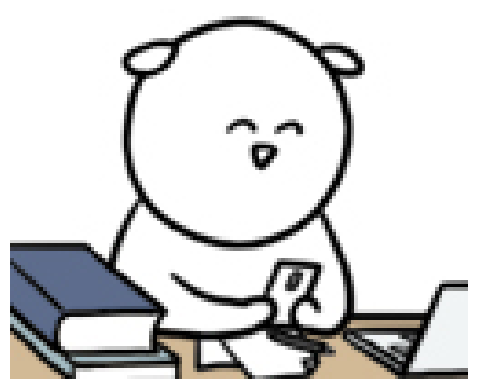

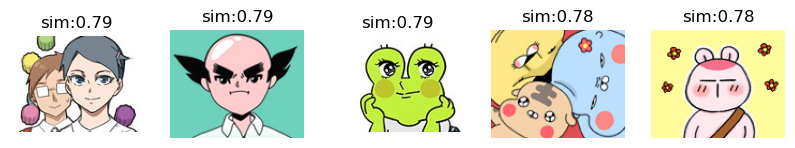

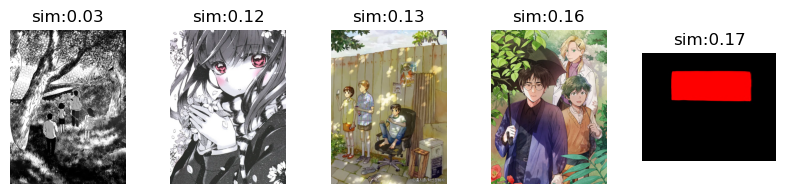

In [21]:
cache, sim = show_result(6834, sim, cache) # 대학일기

146477.203125


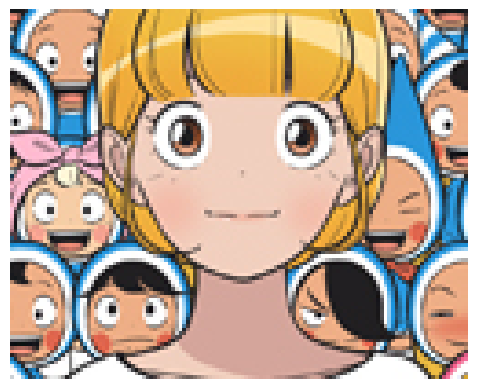

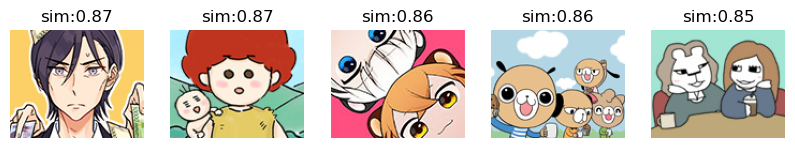

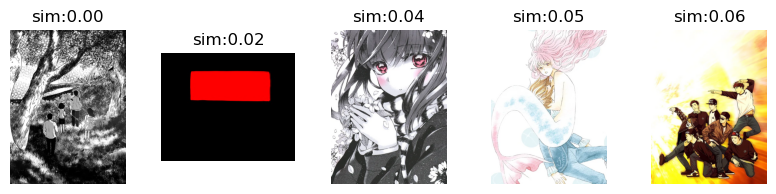

In [22]:
cache, sim = show_result(6538, sim, cache) # 유미의 세포들

135001.234375


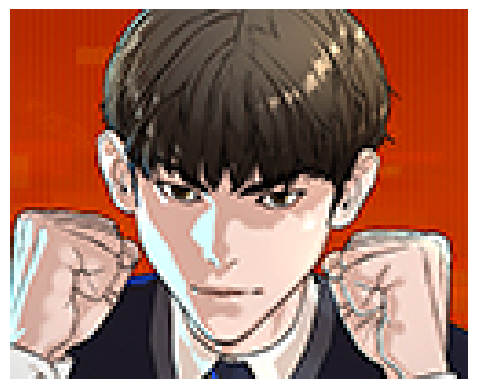

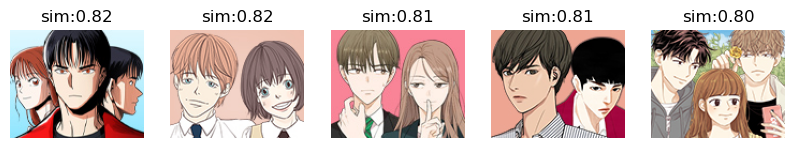

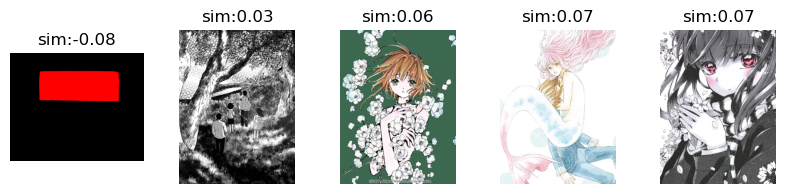

In [23]:
cache, sim = show_result(6446, sim, cache) # 싸움독학

141413.390625


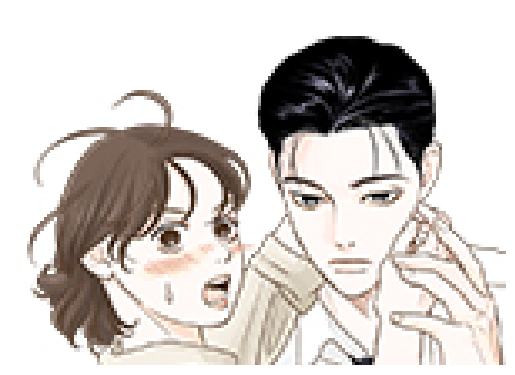

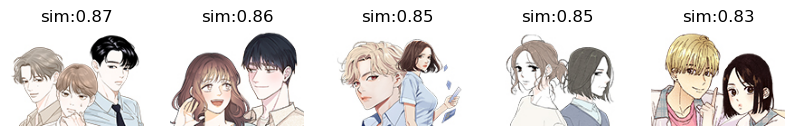

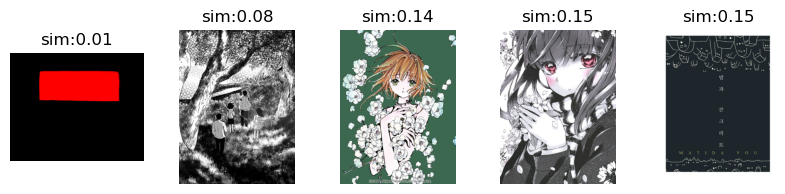

In [24]:
cache, sim = show_result(712, sim, cache) # 내일도 출근!

146818.9375


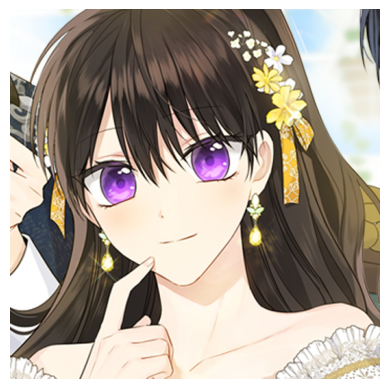

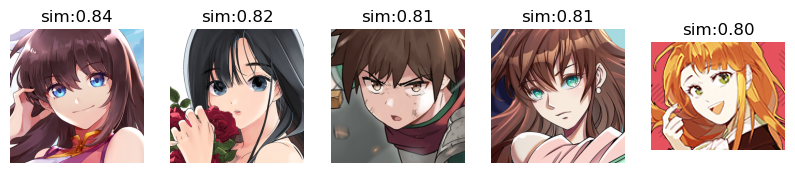

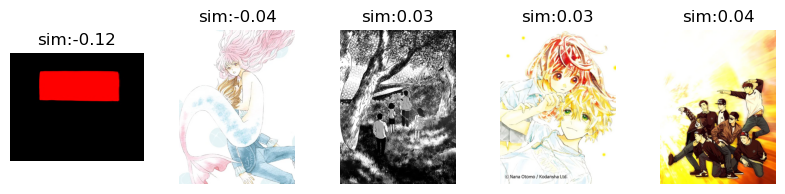

In [25]:
cache, sim = show_result(1242, sim, cache) # 사실은 내가 진짜였다

139995.515625


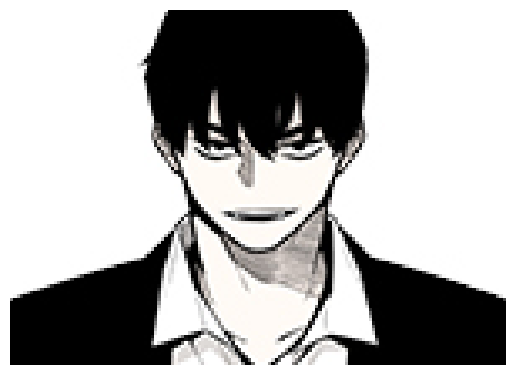

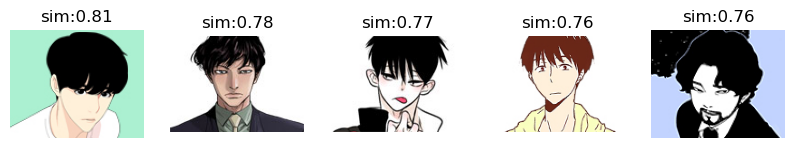

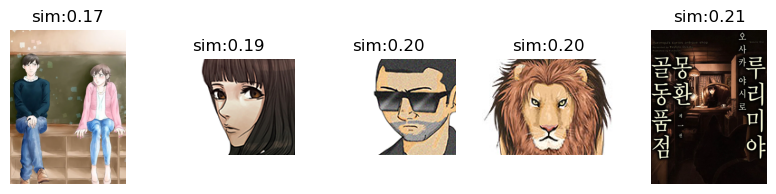

In [26]:
cache, sim = show_result(116, sim, cache) # 돈나무

137199.359375


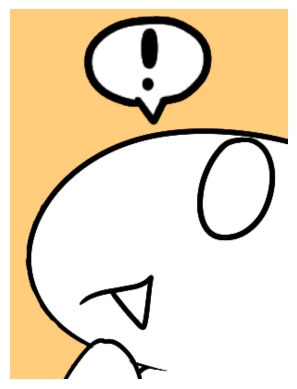

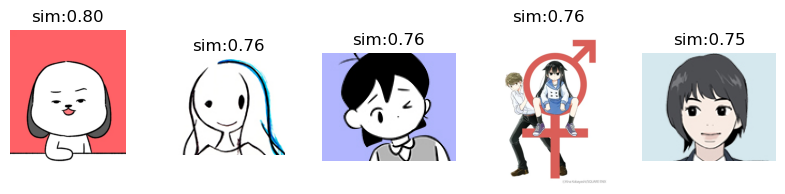

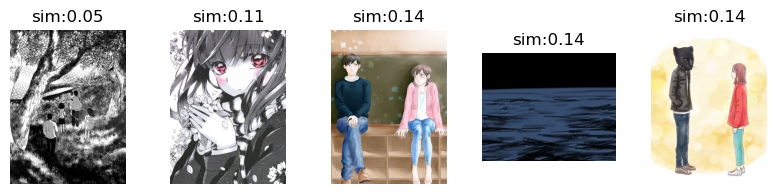

In [27]:
cache, sim = show_result(3410, sim, cache) # 레바툰

140172.921875


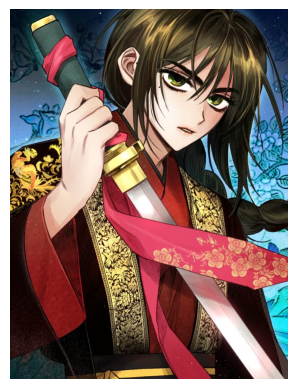

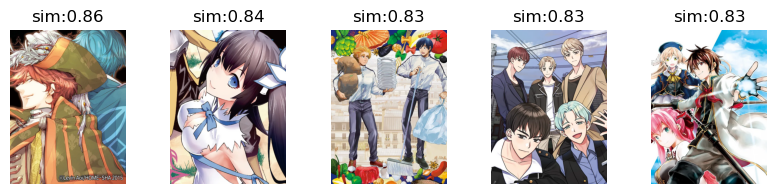

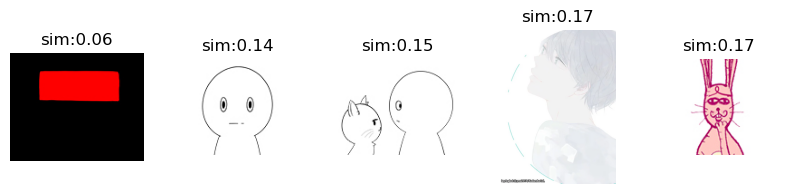

In [28]:
cache, sim = show_result(3434, sim, cache) # 무명의 일기

134164.0


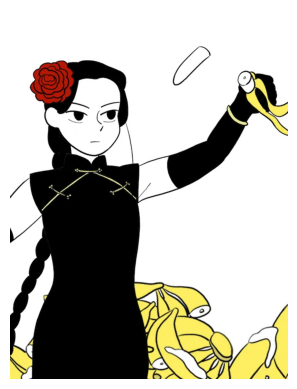

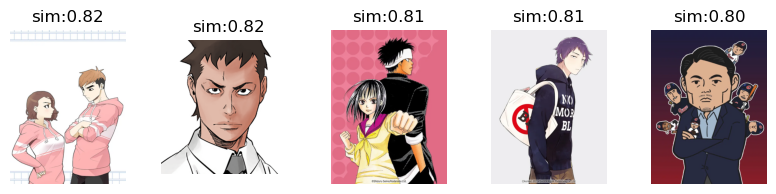

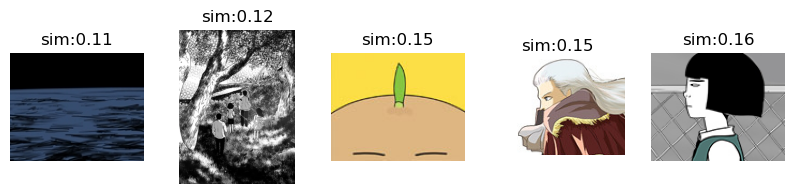

In [29]:
cache, sim = show_result(2550, sim, cache) # 환관제조일기

#### Index Check

In [30]:
webtoons.loc[webtoons['title']=='환관제조일기']

id  p_id   title platform  \
4960  4960  1096  환관제조일기   lezhin   

                                              thumbnail  
4960  https://ccdn.lezhin.com/v2/comics/652875355154...

In [31]:
path = 'thumbs/'

In [32]:
thumb_path.index(path+'lezhin_1096.jpg')

2550